In [38]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
# Load dataset
data = pd.read_csv('data/spotify_cleaned.csv')
print(data.info())

# Feature columns
feature_cols = [
    "danceability",
    "energy",
    "valence",
    "tempo",
    "acousticness",
    "instrumentalness",
    "liveness",
    "speechiness",
    "loudness"
]

# Feature matrix
X = data[feature_cols].values
X_scaled = StandardScaler().fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19419 entries, 0 to 19418
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  19419 non-null  object 
 1   track_name                19419 non-null  object 
 2   track_artist              19419 non-null  object 
 3   track_popularity          19419 non-null  int64  
 4   track_album_id            19419 non-null  object 
 5   track_album_name          19419 non-null  object 
 6   track_album_release_date  19419 non-null  object 
 7   playlist_name             19419 non-null  float64
 8   playlist_id               19419 non-null  object 
 9   playlist_genre            19419 non-null  object 
 10  playlist_subgenre         19419 non-null  float64
 11  danceability              19419 non-null  float64
 12  energy                    19419 non-null  float64
 13  key                       19419 non-null  int64  
 14  loudne

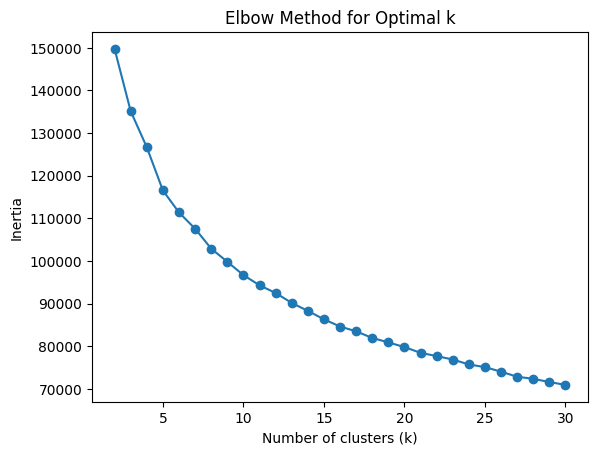

In [40]:
# 6. fit for k clusters using elbow method
k_values = range(2, 31)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# 7. Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [41]:
optimal_k = 15
kmeans_final = KMeans(n_clusters=optimal_k, n_init=20, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_scaled)

In [42]:
spotify_df_clusters = data.copy()

# Initialize all as NaN (songs that weren't used in clustering)
spotify_df_clusters["cluster"] = np.nan

# Assign cluster labels only for rows that were in X_features (same index as X_scaled_df)
spotify_df_clusters.loc[data.index, "cluster"] = cluster_labels

print("Cluster value counts:")
print(spotify_df_clusters["cluster"].value_counts(dropna=False))

Cluster value counts:
cluster
7.0     1642
9.0     1539
12.0    1430
4.0     1430
8.0     1429
2.0     1414
5.0     1320
14.0    1311
10.0    1274
11.0    1256
3.0     1249
1.0     1147
0.0     1095
13.0    1075
6.0      808
Name: count, dtype: int64


Silhouette Score for k=15: 0.1133326195698313


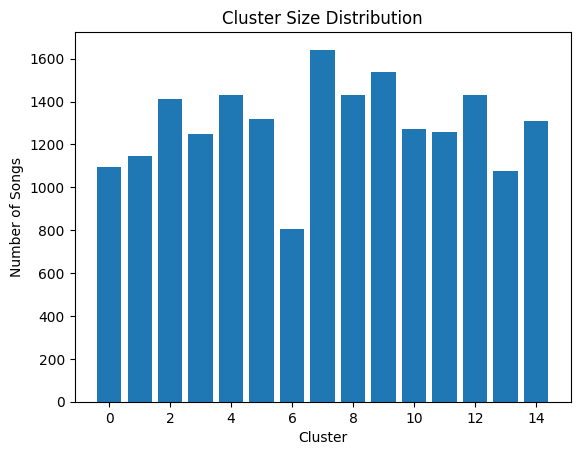

In [43]:
# Silhouette Score
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f'Silhouette Score for k={optimal_k}: {sil_score}')

# Cluster Size Distribution
cluster_sizes = spotify_df_clusters['cluster'].value_counts().sort_index()
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Songs')
plt.title('Cluster Size Distribution')
plt.show()

In [44]:
def find_song_indices(df, track_name=None, track_artist=None):
    mask = pd.Series(True, index=df.index)

    if track_name is not None:
        mask &= df["track_name"].str.contains(
            track_name,
            case=False,
            na=False,
            regex=False,   
        )

    if track_artist is not None:
        mask &= df["track_artist"].str.contains(
            track_artist,
            case=False,
            na=False,
            regex=False,
        )

    return df[mask].index.tolist()


In [45]:
def get_recommendations(song_queries, n_recs=10, random_state=None):
    rng = np.random.default_rng(random_state)

    # 1) Find seed indices and their clusters
    seed_indices = []
    seed_pairs = set()
    seed_clusters = set()

    for song in song_queries:
        track_name = song.get("track_name")
        track_artist = song.get("track_artist")

        if track_name is None:
            continue

        # use your existing helper; pass df explicitly
        idxs = find_song_indices(
            spotify_df_clusters,
            track_name=track_name,
            track_artist=track_artist
        )

        if not idxs:
            print(f"[get_recommendations] Seed not found: {track_name} - {track_artist}")
            continue

        seed_indices.extend(idxs)

        for i in idxs:
            seed_clusters.add(spotify_df_clusters.at[i, "cluster"])
            seed_pairs.add((
                spotify_df_clusters.at[i, "track_name"],
                spotify_df_clusters.at[i, "track_artist"]
            ))

    if not seed_clusters:
        print("[get_recommendations] No seed clusters found; returning empty DataFrame.")
        return pd.DataFrame(columns=spotify_df_clusters.columns)

    # 2) Candidate pool = songs in those clusters
    candidates = spotify_df_clusters[
        spotify_df_clusters["cluster"].isin(seed_clusters)
    ].copy()

    # 3) Exclude all seed songs (track_name + track_artist)
    candidate_pairs = candidates[["track_name", "track_artist"]].apply(tuple, axis=1)
    candidates = candidates[~candidate_pairs.isin(seed_pairs)]

    # 4) Drop duplicates (track_name, track_artist)
    candidates = candidates.drop_duplicates(subset=["track_name", "track_artist"])

    if candidates.empty:
        print("[get_recommendations] No candidate songs after filtering.")
        return candidates

    # 5) Shuffle within each cluster for variety
    #    (and optional reproducibility via random_state)
    grouped = []
    for c, grp in candidates.groupby("cluster"):
        # shuffle using RNG
        grp = grp.sample(frac=1, random_state=rng.integers(0, 1_000_000)).reset_index(drop=True)
        grouped.append(grp)

    # 6) Round-robin across clusters to encourage diversity
    rec_rows = []
    i = 0
    while len(rec_rows) < n_recs and grouped:
        new_grouped = []
        for grp in grouped:
            if i < len(grp):
                rec_rows.append(grp.iloc[i])
                if len(rec_rows) >= n_recs:
                    break
                new_grouped.append(grp)
            else:
                # this cluster ran out of songs
                continue
        grouped = new_grouped
        i += 1
        if not grouped:
            break

    if not rec_rows:
        return pd.DataFrame(columns=candidates.columns)

    recs = pd.DataFrame(rec_rows).reset_index(drop=True)
    return recs.head(n_recs)

In [46]:
# Compute cosine similarity score between user songs and recommended songs
def cosine_similarity_score(user_songs, recommended_songs):
    user_indices = []
    rec_indices = []
    for song in user_songs:
        tname = song.get("track_name")
        aname = song.get("track_artist")
        matches = find_song_indices(data, track_name=tname, track_artist=aname)
        if matches:
            user_indices.append(matches[0])
    for _, row in recommended_songs.iterrows():
        matches = find_song_indices(data, track_name=row["track_name"], track_artist=row["track_artist"])
        if matches:
            rec_indices.append(matches[0])
    if not user_indices or not rec_indices:
        return None
    user_vectors = X_scaled[user_indices]
    rec_vectors = X_scaled[rec_indices]
    sim_matrix = cosine_similarity(user_vectors, rec_vectors)
    return sim_matrix

In [47]:
# Example usage
user_songs = [
    {"track_name": "Don't you forget about me", "track_artist": "Simple Minds"},
    {"track_name": "Don't stop believin'", "track_artist": "Journey"},
    {"track_name": "Tainted Love", "track_artist": "Soft Cell"},
    {"track_name": "Take on Me", "track_artist": "a-ha"},
    {"track_name": "Africa", "track_artist": "Toto"},
    {"track_name": "Eye of the Tiger", "track_artist": "Survivor"},
]
recs = get_recommendations(
    song_queries=user_songs,
    n_recs=10
)

print(recs)
# Calculate and print cosine similarity score mean for each recommended song
sim_matrix = cosine_similarity_score(user_songs, recs)
if sim_matrix is not None:
    sim_means = sim_matrix.mean(axis=0)
    for i, row in recs.iterrows():
        print(f"Recommendation: {row['track_name']} - {row['track_artist']}, Cosine Similarity Score Mean: {sim_means[i]:.4f}")

[get_recommendations] Seed not found: Don't you forget about me - Simple Minds
                 track_id                 track_name           track_artist  \
0  4TkXg2v2OeFBaJLXz1MNFd                  Novocaine          Twin Atlantic   
1  35AoMYhAm6slJkJTB5HOge      Ojala Que Llueva Cafe  Juan Luis Guerra 4.40   
2  4gbVRS8gloEluzf0GzDOFc                       Maps               Maroon 5   
3  7LeQ55Z5jPBB0ggYJtAiYO                  Brindemos               Anuel AA   
4  0szKeS5WTmnMzFIgJCQllo         It Don't Come Easy            Ringo Starr   
5  7ltEDsGu3Zggmpay2RFCOL  I Wanna Feel - Radio Edit             Secondcity   
6  53Q2NHdKe89yMdpPJOp8HR               Cosita Dulce              Cecy Leos   
7  2R5uY1gbIKzGB1yAOH067s                   Over You               Daughtry   
8  1yAPglN5AGf7UoLK062ZYq              Wish You Well                 Sigala   
9  3eA3GaCrWwdz6x4QHI9Kj1                     Impala      LaMorris Williams   

   track_popularity          track_album_id        

In [48]:
import random 
# Backtest playlist
def backtest_playlist(playlistname, seed=.8, n_rec=10):
    # Load playlist data with error handling for malformed CSV
    playlist_df = pd.read_csv('data/spotify_playlists.csv', on_bad_lines='skip', engine='python')
    
    # Convert playlistname column to string to avoid float/type issues
    playlist_df['playlistname'] = playlist_df['playlistname'].astype(str)

    # List of tuples (track_name, track_artist) for all songs in the playlist
    playlist_songs = list(
        playlist_df[playlist_df['playlistname'] == str(playlistname)][['trackname', 'artistname']].itertuples(index=False, name=None)
    )

    songCount = len(playlist_songs)
    
    # Remove songs not in data
    valid_songs = []
    for track_name, track_artist in playlist_songs:
        matches = find_song_indices(data, track_name=track_name, track_artist=track_artist)
        if matches:
            valid_songs.append((track_name, track_artist))

    validCount = len(valid_songs)

    # remove seed songs randomly
    seed_songs = random.sample(valid_songs, min(int(np.floor(validCount*seed)), validCount))

    # remove seed songs from valid songs
    for song in seed_songs:
        valid_songs.remove(song)

    # Prepare song queries for recommendation
    song_queries = [
        {"track_name": track_name, "track_artist": track_artist}
        for track_name, track_artist in seed_songs
    ]

    recs = get_recommendations(
        song_queries=song_queries,
        n_recs=n_rec
    )

    display(recs)

    # Print summary
    print(f"\nBacktest Summary for Playlist: {playlistname}")
    print(f"Total songs in playlist: {songCount}")
    print(f"Valid songs in dataset: {validCount}")
    print(f"Seed songs used: {len(seed_songs)}")
    print(f"Recommendations generated: {len(recs)}")

    # Calculate how many recommendations were actually in the original playlist
    rec_in_playlist = 0
    for _, row in recs.iterrows():
        if (row['track_name'], row['track_artist']) in valid_songs:
            rec_in_playlist += 1


    print(f"Recommendations in original playlist: {rec_in_playlist}")

In [49]:
backtest_playlist('Songs I Need', .8, 50)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock,cluster
0,4WnwGiP22c2TwC1kaiDHzQ,Ostblocknutten,Kollegah,0,5RGWq6TzBKUQ70zR1pHyTZ,Hoodtape (Vol. 1 / X-Mas Edition),2010,0.001287,5GA8GDo7RQC3JEanT81B3g,rap,...,-0.057177,-1.065023,159573,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4HSD7R7gdVaprM52HQbAkh,Finders Keepers,You Me At Six,0,4uC7zTuKQvssFjKEmLB8x3,Take Off Your Colours,2008,0.004068,1YgWQAs1s77NzieIH4ARKn,pop,...,-0.687303,0.208624,194280,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,13ZyrkCDmRz5xY3seuAWYk,Hear Me Calling,Juice WRLD,79,1GYVNOzwhx1nMcIJDogSNp,Death Race For Love,2019-03-08,0.003759,7kzKtw5vug3IIxKfLadi8A,rap,...,-0.159972,-1.306326,189977,0.0,0.0,0.0,0.0,1.0,0.0,2.0
3,5OwponLnwCAYnWql6cwBru,Drain You,Nirvana,58,2uEf3r9i2bnxwJQsxQ0xQ7,Nevermind (Deluxe Edition),1991-09-26,0.002987,4PjiT7SWnUsTTTvKOuR76f,rock,...,-1.504913,0.639989,223880,0.0,0.0,0.0,0.0,0.0,1.0,4.0
4,0jr6tT2vc4cIFPHb6wufG3,Promise,Romeo Santos,68,6a3RDPcFamZvFCi8VeXWkK,Fórmula Vol. 1 (Deluxe Edition),2012-08-27,0.003193,2rg9LCyvaMQvnCE2hVndpR,latin,...,1.051435,0.626758,252253,0.0,1.0,0.0,0.0,0.0,0.0,5.0
5,6Q1LtmZPFRGNZbH6VdarBQ,Пламя,IC3PEAK,42,1x5XZhwID74j0tqkcU6hCy,Сладкая жизнь,2017-11-07,0.002678,19WuHd4MxWLzE1fpMmw4S4,rap,...,-2.214181,0.751759,234000,0.0,0.0,0.0,0.0,1.0,0.0,6.0
6,3YuaBvuZqcwN3CEAyyoaei,Like a Stone,Audioslave,75,78guAsers0klWl6RwzgDLd,Audioslave,2002-11-17,0.003141,5BygwTQ3OrbiwVsQhXFHMz,rock,...,-0.083993,-0.385068,293960,0.0,0.0,0.0,0.0,0.0,1.0,7.0
7,2kWJXkOSbEHAF2NucFv9SN,Roll the Dice,Color Me Badd,15,17mrdLXkhmlY36jRm9cUbw,C.M.B.,1991-07-23,0.001545,3X4HmijjKdwwLonCrOOEAZ,r&b,...,0.953076,-0.230858,288200,0.0,0.0,0.0,1.0,0.0,0.0,8.0
8,4XmsMIMjvDIFEjeY3ycMzW,All 4 Love,Color Me Badd,51,17mrdLXkhmlY36jRm9cUbw,C.M.B.,1991-07-23,0.004480,3ykXidKLz1eYPvuGoFlD1e,r&b,...,1.172152,-0.450489,211493,0.0,0.0,0.0,1.0,0.0,0.0,10.0
9,2dLxWmivrCHjJbYAkVNFyH,Scared of Love,Rudimental,49,0ORqx9M6ak7kqDwYUBwvdK,Toast to Our Differences (Deluxe Edition),2019-01-25,0.004223,4Bi8VLtaSu0JILliif8lH6,pop,...,-0.857101,0.048596,203000,0.0,0.0,1.0,0.0,0.0,0.0,12.0



Backtest Summary for Playlist: Songs I Need
Total songs in playlist: 367
Valid songs in dataset: 52
Seed songs used: 41
Recommendations generated: 50
Recommendations in original playlist: 0


In [50]:
backtest_playlist('chill out', .8, 50)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,valence,tempo,duration_ms,playlist_genre_edm,playlist_genre_latin,playlist_genre_pop,playlist_genre_r&b,playlist_genre_rap,playlist_genre_rock,cluster
0,1NHlyKgtR4roNylOhidKSv,Girls Have Fun (feat. G-Eazy & Rich The Kid),Tyga,69,1KLUE6sVMdRUxD3MRUyS0M,Girls Have Fun (feat. G-Eazy & Rich The Kid),2019-01-23,0.001133,37i9dQZF1DWVdgXTbYm2r0,rap,...,0.577548,-0.747007,175711,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,3gy6JIMU5Z7e9Yswdv49fG,Decision (feat. Tyler Carter),ONE OK ROCK,47,5yyxuxoqWqmYIJcORvvnpL,35xxxv (Deluxe Edition),2015-09-25,0.000824,2gt9IfM8ASNiDzqg5jKyR5,rock,...,-1.491512,1.528571,224667,0.0,0.0,0.0,0.0,0.0,1.0,4.0
2,0ltIbWognQFt70SBWi0VEh,Te Doy Mi Vida,Lucas Arnau,6,4TWMP9VO2Y57azt0OPPC2U,Un Poco Más,2004-06-22,0.003965,4BmnnqWEQAamNoVjtjrQJP,latin,...,1.064848,-0.946831,274813,0.0,1.0,0.0,0.0,0.0,0.0,5.0
3,6pWsAhgMZzoLAJ0hJP41iq,Fire,Barns Courtney,4,2r9U3Cdv0A0g1t9UqOqyEB,Fire,2015-10-23,0.001751,56dbowk1V5ycS5jW7DSvi5,rock,...,-0.378960,-0.361483,197523,0.0,0.0,0.0,0.0,0.0,1.0,6.0
4,2Rl7eTc2aCUte9eVEvi4Ce,Mistakes,Jeremy Shayne,37,7kk12d6xFsi023jIYHkR4S,Mistakes,2018-03-02,0.001905,06zrBJ5cts5aemZmqe80J7,latin,...,-1.138584,-0.517267,212000,0.0,1.0,0.0,0.0,0.0,0.0,9.0
5,6XgHh91UD5IMETc9IEiawG,Every Little Thing I Do - Remix,Soul For Real,4,18YTWlfaAMO3Lr49bfudoA,"The New Jack Swing Collection, Vol. 2",2014-11-07,0.002781,0dmInkymNnOTWvEFamSNzb,r&b,...,1.087203,-0.798630,303494,0.0,0.0,0.0,1.0,0.0,0.0,10.0
6,0tICYNayWWhH9GPeFrfjfD,This Girl (Kungs Vs. Cookin' On 3 Burners) - K...,Kungs,20,3nxlM2DFwij3JVP55yNRya,Layers,2016-11-04,0.003656,1CMvQ4Yr5DlYvYzI0Vc2UE,pop,...,-0.209134,0.207713,195547,0.0,0.0,1.0,0.0,0.0,0.0,12.0
7,60VcYHxoyOdZyFb1EaKJdN,Up On Cripple Creek - Remastered 2000,The Band,60,0nPrnmv6maJLLaPpy1cWGB,The Band (Expanded Edition),1969-09-22,0.002523,1uKFRCQYci8kVgMy3xzTVH,rock,...,1.869706,1.026162,274893,0.0,0.0,0.0,0.0,0.0,1.0,13.0
8,28GbaBYFpYi1J61fXnGSfd,Apricot Princess,Rex Orange County,63,2NBVxjZcbH5H1N1Ab2ExDH,Apricot Princess,2017-04-26,0.002626,1E5VdGGWkpDQ682gdvJAZH,pop,...,-1.277080,-0.208536,238480,0.0,0.0,1.0,0.0,0.0,0.0,14.0
9,5Zi5RHFI0tWKkzoiob2OtU,Crack A Bottle,Eminem,0,1tmqPFNK1Bu1QbJSy65lkC,Crack A Bottle,2009-01-01,0.002472,0275i1VNfBnsNbPl0QIBpG,rap,...,-0.772203,-1.716376,314560,0.0,0.0,0.0,0.0,1.0,0.0,3.0



Backtest Summary for Playlist: chill out
Total songs in playlist: 204
Valid songs in dataset: 23
Seed songs used: 18
Recommendations generated: 50
Recommendations in original playlist: 0
